In [1]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
from urllib.parse import quote

import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.alert import Alert

from datetime import datetime, timedelta

import numpy as np
import statistics
from matplotlib import font_manager, rc 
import matplotlib.pyplot as plt
import matplotlib as mpl

#마이너스 표시
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

# 파일 전처리

1. 개봉일과 기준일 날짜형식으로 바꾸기
2. 개봉일, 기준일 기준 - 연도, 월 컬럼 각각 추가
3. 매출액과 관객수, 스크린수, 상영횟수가 모두 0인 행 삭제
4. 등급 이상값 확인 후 변경
5. excel로 저장 (데이터형식을 유지하기위함)
 - 파일명 : ./data/완_기간별_일별_170101_to_230509_ver2.xlsx

In [2]:
movie_df = pd.read_csv("./data/완_기간별_일별_170101_to_230509_ver1.csv")
movie_df.head()

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,배우,기준일,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수
0,1,너의 이름은.,2017-01-04 00:00:00,일본,일본,NaN,플러스엠 엔터테인먼트,12세이상관람가,"애니메이션,드라마,멜로/로맨스",신카이 마코토,"카미키 류노스케,카미시라이시 모네,나가사와 마사미,이치하라 에수코,유키 아오이,시마...",2017-01-08,2809088900,9745292442,333008,1182465,947,4101
1,3,모아나,2017-01-12 00:00:00,미국,미국,NaN,월트디즈니컴퍼니코리아 유한책임회사,전체관람가,애니메이션,"론 클레멘츠,존 머스커","드웨인 존슨,아우이 크라발호,알란 터딕,제메인 클레멘트,테무에라 모리슨",2017-01-08,7738000,9712000,910,1192,6,6
2,4,패신저스,2017-01-04 00:00:00,미국,미국,NaN,유니버설픽쳐스인터내셔널 코리아(유),12세이상관람가,"어드벤처,SF",모튼 틸덤,"크리스 프랫,제니퍼 로렌스,마이클 쉰,앤디 가르시아,로렌스 피쉬번",2017-01-08,1107502600,4176443418,129810,504393,608,2272
3,5,얼라이드,2017-01-11 00:00:00,미국,미국,NaN,롯데쇼핑㈜롯데엔터테인먼트,15세이상관람가,"스릴러,드라마,멜로/로맨스",로버트 저메키스,"브래드 피트,마리옹 꼬띠아르,리지 캐플란,매튜 구드,자레드 해리스",2017-01-08,0,32151000,0,3730,0,0
4,6,어쌔신 크리드,2017-01-11 00:00:00,미국,"미국,영국,프랑스",NaN,이십세기폭스코리아(주),15세이상관람가,"액션,어드벤처,판타지,SF",저스틴 커젤,"마이클 패스벤더,마리옹 꼬띠아르,아리안 라베드,제레미 아이언스,브렌단 글리슨,마이클...",2017-01-08,0,8289000,0,790,0,0


In [3]:
# 개봉일과 기준일 날짜형식으로 바꾸기
movie_df['개봉일'] = pd.to_datetime(movie_df['개봉일'])
movie_df['기준일'] = pd.to_datetime(movie_df['기준일'])
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363272 entries, 0 to 363271
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   순위      363272 non-null  int64         
 1   영화명     363272 non-null  object        
 2   개봉일     363272 non-null  datetime64[ns]
 3   대표국적    363272 non-null  object        
 4   국적      363272 non-null  object        
 5   제작사     137977 non-null  object        
 6   배급사     363048 non-null  object        
 7   등급      363258 non-null  object        
 8   장르      362698 non-null  object        
 9   감독      338709 non-null  object        
 10  배우      285173 non-null  object        
 11  기준일     363272 non-null  datetime64[ns]
 12  매출액     363272 non-null  int64         
 13  누적매출액   363272 non-null  int64         
 14  관객수     363272 non-null  int64         
 15  누적관객수   363272 non-null  int64         
 16  스크린수    363272 non-null  int64         
 17  상영횟수    363272 non-null  int6

In [4]:
# 개봉일, 기준일 기준 - 연도, 월 컬럼 각각 추가
movie_df['기준연도'] = movie_df['기준일'].apply(lambda x : x.year)
movie_df['기준월'] = movie_df['기준일'].apply(lambda x : x.month)
movie_df['개봉연도'] = movie_df['개봉일'].apply(lambda x : x.year)
movie_df['개봉월'] = movie_df['개봉일'].apply(lambda x : x.month)
movie_df.head(1)

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,...,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,1,너의 이름은.,2017-01-04,일본,일본,NaN,플러스엠 엔터테인먼트,12세이상관람가,"애니메이션,드라마,멜로/로맨스",신카이 마코토,...,2809088900,9745292442,333008,1182465,947,4101,2017,1,2017,1


In [5]:
# 매출액, 관객수, 스크린수, 상영횟수 모두가 0인 행 제외
movie_df = movie_df[(movie_df['매출액']!=0)&(movie_df['관객수']!=0)&
                   (movie_df['스크린수']!=0)&(movie_df['상영횟수']!=0)]

In [6]:
len(movie_df)

183006

In [7]:
# 등급 이상 값 확인
movie_df['등급'].unique()

array(['12세이상관람가', '전체관람가', '청소년관람불가', '15세이상관람가', '15세관람가', nan,
       '12세이상관람가,15세이상관람가', '연소자관람불가,청소년관람불가', '12세관람가'], dtype=object)

In [8]:
len(movie_df[movie_df['등급']=='12세이상관람가,15세이상관람가'])
movie_df[movie_df['등급']=='12세이상관람가,15세이상관람가']["영화명"].unique()

array(['라이크 크레이지'], dtype=object)

In [9]:
len(movie_df[movie_df['등급']=='연소자관람불가,청소년관람불가'])
movie_df[movie_df['등급']=='연소자관람불가,청소년관람불가']["영화명"].unique()

array(['죽어도 좋은 경험: 천사여 악녀가 되라'], dtype=object)

In [10]:
len(movie_df[movie_df['등급']=='12세관람가'])
movie_df[movie_df['등급']=='12세관람가']["영화명"].unique()

array(['던전 앤 드래곤: 도적들의 명예'], dtype=object)

In [11]:
# 등급 이상 값 확인 후 변경
movie_df['등급'].replace(['15세관람가', '12세이상관람가,15세이상관람가', '연소자관람불가,청소년관람불가', '12세관람가'],['15세이상관람가', '12세이상관람가', '청소년관람불가', '12세이상관람가'], inplace=True)
movie_df['등급'].unique()

array(['12세이상관람가', '전체관람가', '청소년관람불가', '15세이상관람가', nan], dtype=object)

In [18]:
movie_df.to_excel('./data/완_기간별_일별_170101_to_230509_ver2.xlsx', index=False)

In [19]:
movie_df.to_csv('./data/완_기간별_일별_170101_to_230509_ver2.csv', index=False)

# 연도별 총 매출 시각화 (2017~2022)

In [2]:
movie_df = pd.read_excel('./data/완_기간별_일별_170101_to_230509_ver2.xlsx')
movie_df.head()

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,...,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,1,너의 이름은.,2017-01-04,일본,일본,NaN,플러스엠 엔터테인먼트,12세이상관람가,"애니메이션,드라마,멜로/로맨스",신카이 마코토,...,2809088900,9745292442,333008,1182465,947,4101,2017,1,2017,1
1,3,모아나,2017-01-12,미국,미국,NaN,월트디즈니컴퍼니코리아 유한책임회사,전체관람가,애니메이션,"론 클레멘츠,존 머스커",...,7738000,9712000,910,1192,6,6,2017,1,2017,1
2,4,패신저스,2017-01-04,미국,미국,NaN,유니버설픽쳐스인터내셔널 코리아(유),12세이상관람가,"어드벤처,SF",모튼 틸덤,...,1107502600,4176443418,129810,504393,608,2272,2017,1,2017,1
3,9,눈의 여왕 3: 눈과 불의 마법대결,2017-01-04,러시아,러시아,NaN,(주)이수C&E,전체관람가,"애니메이션,어드벤처,가족,판타지",알렉세이 트시칠린,...,535436000,1828596400,67605,242171,524,1163,2017,1,2017,1
4,10,사랑하기 때문에,2017-01-04,한국,한국,(주)에이디사공육,(주)넥스트엔터테인먼트월드(NEW),12세이상관람가,"코미디,멜로/로맨스",주지홍,...,450612400,1968850940,53856,246167,542,1533,2017,1,2017,1


In [3]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183006 entries, 0 to 183005
Data columns (total 22 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   순위      183006 non-null  int64         
 1   영화명     183006 non-null  object        
 2   개봉일     183006 non-null  datetime64[ns]
 3   대표국적    183006 non-null  object        
 4   국적      183006 non-null  object        
 5   제작사     66060 non-null   object        
 6   배급사     182938 non-null  object        
 7   등급      183004 non-null  object        
 8   장르      182901 non-null  object        
 9   감독      172295 non-null  object        
 10  배우      157239 non-null  object        
 11  기준일     183006 non-null  datetime64[ns]
 12  매출액     183006 non-null  int64         
 13  누적매출액   183006 non-null  int64         
 14  관객수     183006 non-null  int64         
 15  누적관객수   183006 non-null  int64         
 16  스크린수    183006 non-null  int64         
 17  상영횟수    183006 non-null  int6

In [5]:
movie_df['기준일'].value_counts().to_frame()

,기준일
2019-11-08,121
2017-12-01,119
2020-11-28,119
2020-11-24,118
2019-11-19,117
...,...
2017-01-02,14
2017-01-03,14
2017-01-07,12
2017-01-08,11


In [6]:
movie_df['기준일'].max()

Timestamp('2023-05-06 00:00:00')

In [4]:
movie_df_info = movie_df[['영화명','개봉연도','개봉월','기준연도','기준월','매출액','관객수']]
movie_df_info

,영화명,개봉연도,개봉월,기준연도,기준월,매출액,관객수
0,너의 이름은.,2017,1,2017,1,2809088900,333008
1,모아나,2017,1,2017,1,7738000,910
2,패신저스,2017,1,2017,1,1107502600,129810
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,2017,1,535436000,67605
4,사랑하기 때문에,2017,1,2017,1,450612400,53856
...,...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,2017,1,4881000,209
183002,걱정말아요,2017,1,2017,1,502000,71
183003,비밀객잔의 결투,2017,1,2017,1,7000,2
183004,소림사 무림 탐정-취의전장,2017,1,2017,1,7000,2


In [9]:
# 총매출을 연도와 월로 그룹화
month_sum = movie_df_info.groupby(["기준연도","기준월"])['매출액'].agg(['sum'])
month_sum.columns = ['총매출']
month_sum

총매출
기준연도 기준월              
2017 1    149844517327
     2    119222010654
     3    110757411220
     4     89172406575
     5    148934911530
...                ...
2023 1    123808074711
     2     62335465454
     3     79804374946
     4     69957651381
     5     34446431119

[77 rows x 1 columns]

In [10]:
month_sum.reset_index(inplace=True)
month_sum

,기준연도,기준월,총매출
0,2017,1,149844517327
1,2017,2,119222010654
2,2017,3,110757411220
3,2017,4,89172406575
4,2017,5,148934911530
...,...,...,...
72,2023,1,123808074711
73,2023,2,62335465454
74,2023,3,79804374946
75,2023,4,69957651381


In [11]:
# 연도별 쪼개기
month_sum_2017 = month_sum[month_sum['기준연도']==2017]
month_sum_2018 = month_sum[month_sum['기준연도']==2018]
month_sum_2019 = month_sum[month_sum['기준연도']==2019]
month_sum_2020 = month_sum[month_sum['기준연도']==2020]
month_sum_2021 = month_sum[month_sum['기준연도']==2021]
month_sum_2022 = month_sum[month_sum['기준연도']==2022]
month_sum_2023 = month_sum[month_sum['기준연도']==2023]

In [12]:
month_sum_2017

,기준연도,기준월,총매출
0,2017,1,149844517327
1,2017,2,119222010654
2,2017,3,110757411220
3,2017,4,89172406575
4,2017,5,148934911530
5,2017,6,120486520438
6,2017,7,167282584065
7,2017,8,233519041096
8,2017,9,100963016463
9,2017,10,174430622831


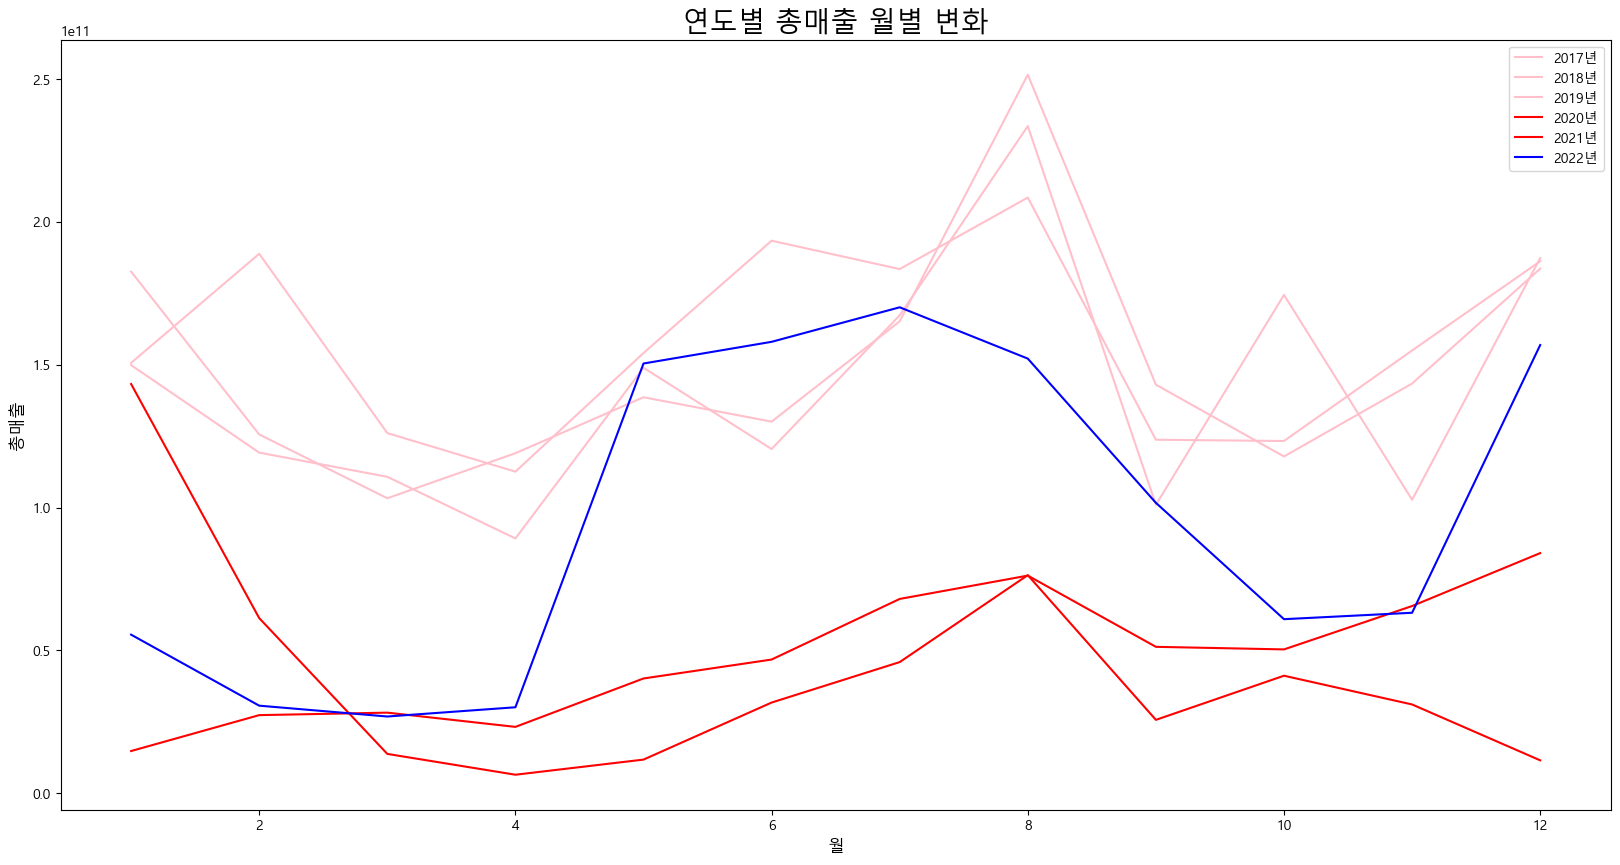

In [21]:
# 연도별 월별 총매출 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(month_sum_2017['기준월'],month_sum_2017['총매출'], color="pink", label="2017년")
ax.plot(month_sum_2018['기준월'],month_sum_2018['총매출'], color="pink", label="2018년")
ax.plot(month_sum_2019['기준월'],month_sum_2019['총매출'], color="pink", label="2019년")
ax.plot(month_sum_2020['기준월'],month_sum_2020['총매출'], color="red", label="2020년")
ax.plot(month_sum_2021['기준월'],month_sum_2021['총매출'], color="red", label="2021년")
ax.plot(month_sum_2022['기준월'],month_sum_2022['총매출'], color="blue", label="2022년")

ax.legend(loc="best")
ax.set_title('연도별 총매출 월별 변화', size=20)
ax.set_xlabel('월',size=12)
ax.set_ylabel('총매출',size=12)
plt.show()

In [18]:
year_sum = movie_df_info.groupby(["기준연도"])['매출액'].agg(['sum'])
year_sum

,sum
기준연도,
2017,1704688087463
2018,1803723964724
2019,1905789216740
2020,499808908001
2021,575737892070
2022,1156311591025
2023,370351997611


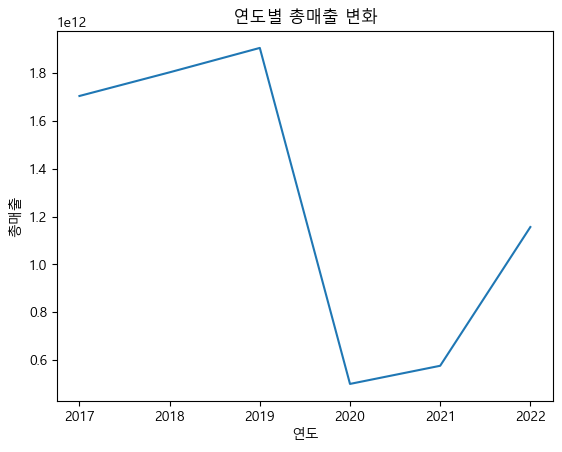

In [19]:
# 연도별 총매출 변화
plt.plot(year_sum['sum'][:-1].index, year_sum['sum'][:-1])
plt.title("연도별 총매출 변화")
plt.xlabel('연도')
plt.ylabel('총매출')
plt.show()

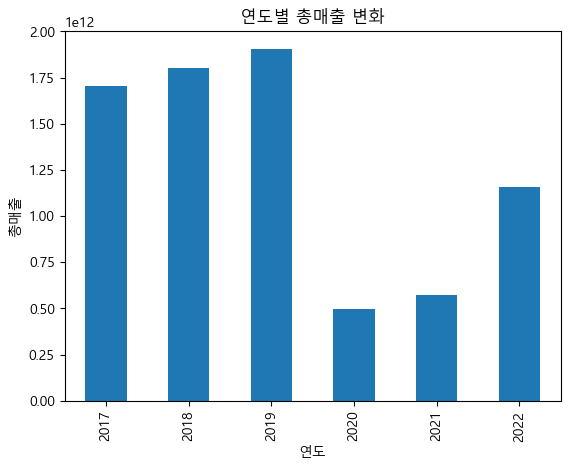

In [20]:
year_sum['sum'][:-1].plot(kind='bar')
plt.title("연도별 총매출 변화")
plt.xlabel('연도')
plt.ylabel('총매출')
plt.show()

# 분기별 매출 분석

In [7]:
sales_quarter = movie_df[['영화명','기준연도','기준월','매출액','관객수','장르']].copy()
sales_quarter

,영화명,기준연도,기준월,매출액,관객수,장르
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스"
1,모아나,2017,1,7738000,910,애니메이션
2,패신저스,2017,1,1107502600,129810,"어드벤처,SF"
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,535436000,67605,"애니메이션,어드벤처,가족,판타지"
4,사랑하기 때문에,2017,1,450612400,53856,"코미디,멜로/로맨스"
...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,4881000,209,공연
183002,걱정말아요,2017,1,502000,71,드라마
183003,비밀객잔의 결투,2017,1,7000,2,"액션,어드벤처,드라마"
183004,소림사 무림 탐정-취의전장,2017,1,7000,2,액션


In [8]:
def quarter_category(month):
    quarter = "-"
    if month <= 3:
        quarter = "1분기"
    elif month <= 6:
        quarter = "2분기"
    elif month <= 9:
        quarter = "3분기"
    elif month <= 12:
        quarter = "4분기"
    else:
        quarter = "-"
    return quarter

sales_quarter['분기'] = sales_quarter['기준월'].apply(lambda x : quarter_category(x))
sales_quarter.head(1)

,영화명,기준연도,기준월,매출액,관객수,장르,분기
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스",1분기


In [12]:
sales_quarter_year = sales_quarter.groupby(['기준연도', '분기'])['매출액'].agg(['sum'])
sales_quarter_year.reset_index(inplace=True)
sales_quarter_year

,기준연도,분기,sum
0,2017,1분기,379823939201
1,2017,2분기,358593838543
2,2017,3분기,501764641624
3,2017,4분기,464505668095
4,2018,1분기,411422605739
5,2018,2분기,387683259532
6,2018,3분기,559723373677
7,2018,4분기,444894725776
8,2019,1분기,465543422365
9,2019,2분기,460053229414


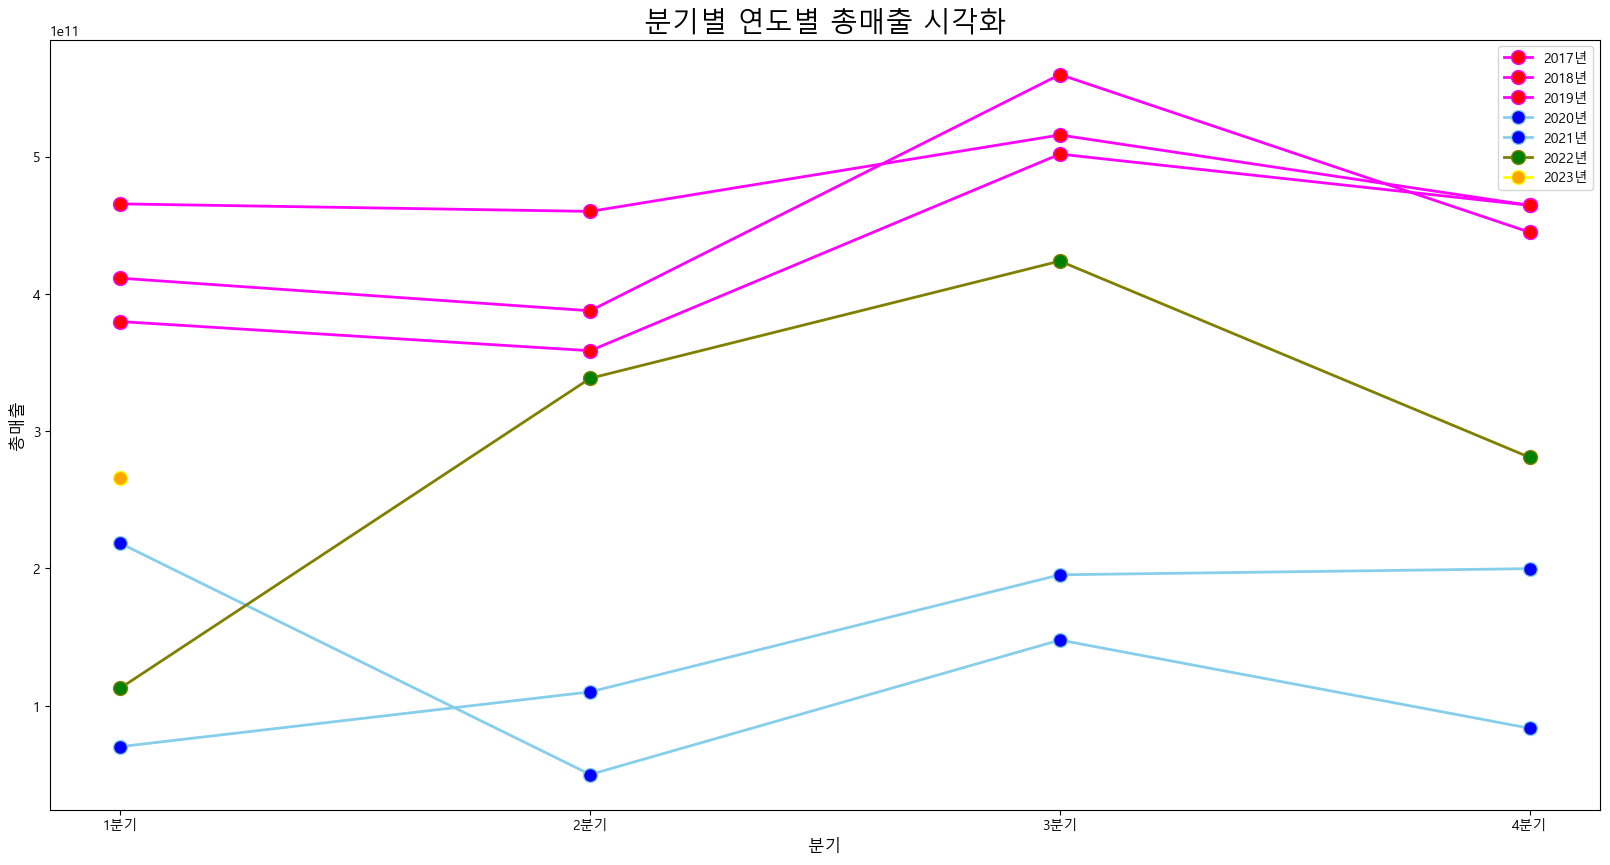

In [29]:
# 분기별 연도별 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

sales_quarter_year_2017 = sales_quarter_year[sales_quarter_year["기준연도"]==2017]
sales_quarter_year_2018 = sales_quarter_year[sales_quarter_year["기준연도"]==2018]
sales_quarter_year_2019 = sales_quarter_year[sales_quarter_year["기준연도"]==2019]
sales_quarter_year_2020 = sales_quarter_year[sales_quarter_year["기준연도"]==2020]
sales_quarter_year_2021 = sales_quarter_year[sales_quarter_year["기준연도"]==2021]
sales_quarter_year_2022 = sales_quarter_year[sales_quarter_year["기준연도"]==2022]
sales_quarter_year_2023 = sales_quarter_year[sales_quarter_year["기준연도"]==2023][:-1]

ax.plot(sales_quarter_year_2017['분기'], sales_quarter_year_2017['sum'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='2017년')
ax.plot(sales_quarter_year_2018['분기'], sales_quarter_year_2018['sum'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='2018년')
ax.plot(sales_quarter_year_2019['분기'], sales_quarter_year_2019['sum'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='2019년')
ax.plot(sales_quarter_year_2020['분기'], sales_quarter_year_2020['sum'], marker='o', markerfacecolor='blue',
        markersize=10, color ="skyblue", linewidth=2, label='2020년')
ax.plot(sales_quarter_year_2021['분기'], sales_quarter_year_2021['sum'], marker='o', markerfacecolor='blue',
        markersize=10, color ="skyblue", linewidth=2, label='2021년')
ax.plot(sales_quarter_year_2022['분기'], sales_quarter_year_2022['sum'], marker='o', markerfacecolor='green',
        markersize=10, color ="olive", linewidth=2, label='2022년')
ax.plot(sales_quarter_year_2023['분기'], sales_quarter_year_2023['sum'], marker='o', markerfacecolor='orange',
        markersize=10, color ="yellow", linewidth=2, label='2023년')


ax.legend(loc="best")
ax.set_title('분기별 연도별 총매출 시각화', size=20)
ax.set_xlabel('분기',size=12)
ax.set_ylabel('총매출',size=12)
# ax.set_xticklabels(col_years, rotation = 90)
plt.show()

# 연도별 관객수 시각화 (2017~2022)

In [63]:
movie_df_info_people = movie_df_info.groupby(['기준연도'])['관객수'].sum().to_frame()
movie_df_info_people

,관객수
기준연도,
2017,213131433
2018,214885747
2019,225349152
2020,57991480
2021,59492547
2022,112287221
2023,34914668


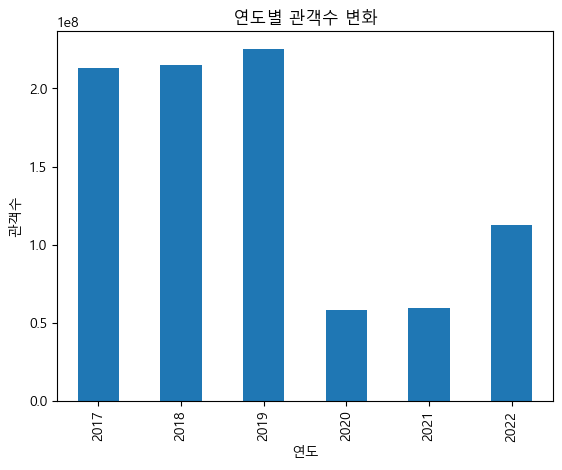

In [64]:
movie_df_info_people['관객수'][:-1].plot(kind='bar')
plt.title("연도별 관객수 변화")
plt.xlabel('연도')
plt.ylabel('관객수')
plt.show()

# 연도별 월별 매출이 발생한 영화수

In [37]:
# 월별 영화수 카운트

In [65]:
sales_count = movie_df_info[['영화명','기준연도','기준월']].copy()
sales_count.drop_duplicates(inplace=True)

print(len(movie_df_info)) 
print(len(sales_count))

183006
24501


C:\Users\tjoeun\AppData\Local\Temp\ipykernel_2684\3563874698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_count.drop_duplicates(inplace=True)


In [27]:
sales_count.head()

,영화명,기준연도,기준월
0,너의 이름은.,2017,1
1,모아나,2017,1
2,패신저스,2017,1
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1
4,사랑하기 때문에,2017,1


In [46]:
sales_count_df = sales_count.groupby(['기준연도','기준월'])['영화명'].count().to_frame()
sales_count_df.reset_index(inplace=True)
sales_count_df

,기준연도,기준월,영화명
0,2017,1,166
1,2017,2,212
2,2017,3,265
3,2017,4,223
4,2017,5,283
...,...,...,...
72,2023,1,272
73,2023,2,254
74,2023,3,309
75,2023,4,292


In [38]:
# 연도별 영화수 카운트

In [66]:
sales_count_year = movie_df_info[['영화명','기준연도']].copy()
sales_count_year.drop_duplicates(inplace=True)

print(len(movie_df_info)) 
print(len(sales_count_year))

183006
14183


C:\Users\tjoeun\AppData\Local\Temp\ipykernel_2684\3360854143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_count_year.drop_duplicates(inplace=True)


In [67]:
sales_count_df = sales_count_year.groupby(['기준연도'])['영화명'].count().to_frame()
sales_count_df

,영화명
기준연도,
2017,1856
2018,2170
2019,2320
2020,2374
2021,2370
2022,2310
2023,783


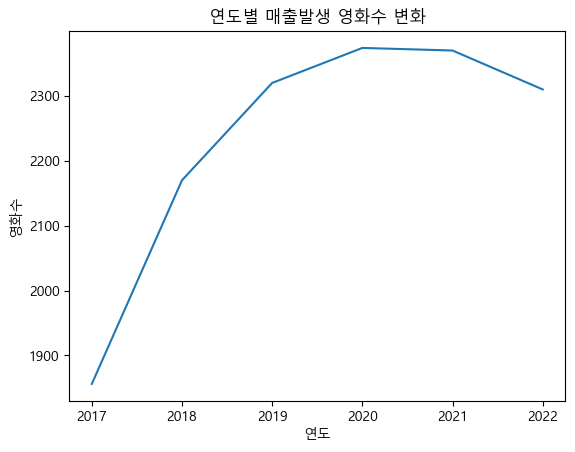

In [81]:
plt.plot(sales_count_df[:-1].index, sales_count_df['영화명'][:-1])
plt.title("연도별 매출발생 영화수 변화")
plt.xlabel('연도')
plt.ylabel('영화수')
plt.show()

In [62]:
sales_count_df[:-1]['영화명']

0    1856
1    2170
2    2320
3    2374
4    2370
5    2310
Name: 영화명, dtype: int64

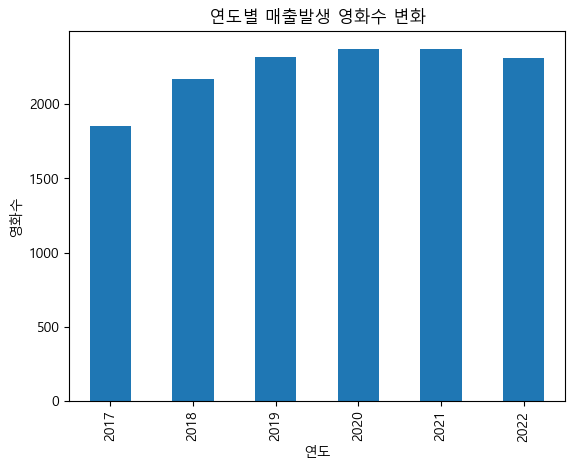

In [80]:
sales_count_df[:-1]['영화명'].plot(kind='bar')
plt.title("연도별 매출발생 영화수 변화")
plt.xlabel('연도')
plt.ylabel('영화수')
plt.show()

# 연도별 개봉한 영화수

In [74]:
open_count = movie_df[['영화명','개봉연도','개봉월']].copy()
open_count.drop_duplicates(inplace=True)

print(len(movie_df_info)) 
print(len(open_count))

183006
11626


C:\Users\tjoeun\AppData\Local\Temp\ipykernel_2684\681396872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_count.drop_duplicates(inplace=True)


In [75]:
open_count_df = open_count.groupby(['개봉연도'])['영화명'].count().to_frame()
open_count_df

,영화명
개봉연도,
2017,1763
2018,1867
2019,1947
2020,1899
2021,1858
2022,1773
2023,519


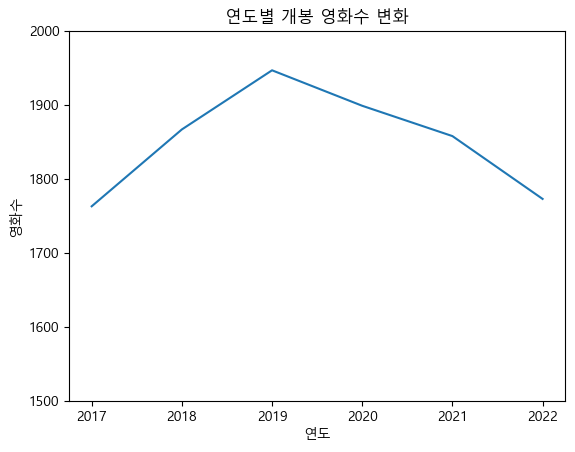

In [78]:
plt.plot(open_count_df['영화명'][:-1].index, open_count_df['영화명'][:-1])
plt.title("연도별 개봉 영화수 변화")
plt.xlabel('연도')
plt.ylabel('영화수')
plt.ylim(1500,2000)
plt.show()

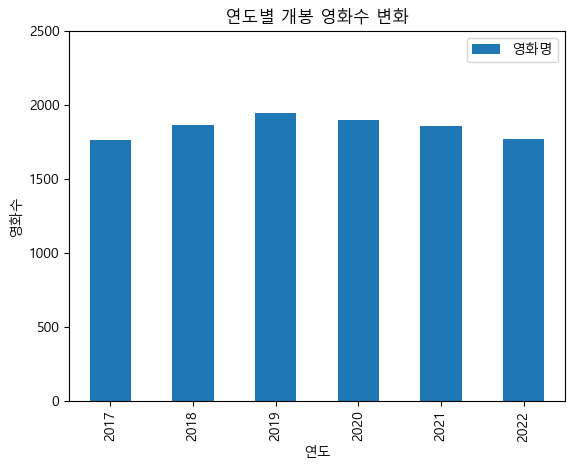

In [79]:
open_count_df[['영화명']][:-1].plot(kind='bar')
plt.title("연도별 개봉 영화수 변화")
plt.xlabel('연도')
plt.ylabel('영화수')
plt.ylim(0,2500)
plt.show()

# 등급별 총매출

In [114]:
movie_grade = movie_df[['영화명', '등급','개봉연도','개봉월','기준연도','기준월','매출액','관객수']]
movie_grade

,영화명,등급,개봉연도,개봉월,기준연도,기준월,매출액,관객수
0,너의 이름은.,12세이상관람가,2017,1,2017,1,2809088900,333008
1,모아나,전체관람가,2017,1,2017,1,7738000,910
2,패신저스,12세이상관람가,2017,1,2017,1,1107502600,129810
3,눈의 여왕 3: 눈과 불의 마법대결,전체관람가,2017,1,2017,1,535436000,67605
4,사랑하기 때문에,12세이상관람가,2017,1,2017,1,450612400,53856
...,...,...,...,...,...,...,...,...
183001,돈 지오반니,전체관람가,2017,1,2017,1,4881000,209
183002,걱정말아요,청소년관람불가,2017,1,2017,1,502000,71
183003,비밀객잔의 결투,12세이상관람가,2017,1,2017,1,7000,2
183004,소림사 무림 탐정-취의전장,12세이상관람가,2017,1,2017,1,7000,2


In [115]:
grade_df = movie_grade[movie_grade['등급'].isnull()==False]
grade_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183004 entries, 0 to 183005
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   영화명     183004 non-null  object
 1   등급      183004 non-null  object
 2   개봉연도    183004 non-null  int64 
 3   개봉월     183004 non-null  int64 
 4   기준연도    183004 non-null  int64 
 5   기준월     183004 non-null  int64 
 6   매출액     183004 non-null  int64 
 7   관객수     183004 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 12.6+ MB


In [116]:
len(grade_df)

183004

In [117]:
grade_df_기준연도 = grade_df.groupby(['등급','기준연도'])['매출액'].agg(['sum'])
grade_df_기준연도

sum
등급       기준연도              
12세이상관람가 2017  540038507289
         2018  990028175503
         2019  722164864226
         2020  158637461033
         2021  284229922769
         2022  634026994169
         2023  257801647911
15세이상관람가 2017  794981752862
         2018  577936937068
         2019  684695135722
         2020  269363764436
         2021  193442625960
         2022  416067429361
         2023   45424363163
전체관람가    2017  177191677466
         2018  150154861593
         2019  427362676004
         2020   55208589132
         2021   63932537661
         2022   91203166657
         2023   45500344027
청소년관람불가  2017  192476149846
         2018   85603988560
         2019   71566540788
         2020   16599088400
         2021   34132805680
         2022   15014000838
         2023   21625642510

In [118]:
grade_df_기준연도.columns=["총매출"]
grade_df_기준연도.reset_index(inplace=True)
grade_df_기준연도.head()

,등급,기준연도,총매출
0,12세이상관람가,2017,540038507289
1,12세이상관람가,2018,990028175503
2,12세이상관람가,2019,722164864226
3,12세이상관람가,2020,158637461033
4,12세이상관람가,2021,284229922769


In [119]:
grade_df_기준연도['총매출'] = round(grade_df_기준연도['총매출']/1000000,1)
grade_df_기준연도.head()

,등급,기준연도,총매출
0,12세이상관람가,2017,540038.5
1,12세이상관람가,2018,990028.2
2,12세이상관람가,2019,722164.9
3,12세이상관람가,2020,158637.5
4,12세이상관람가,2021,284229.9


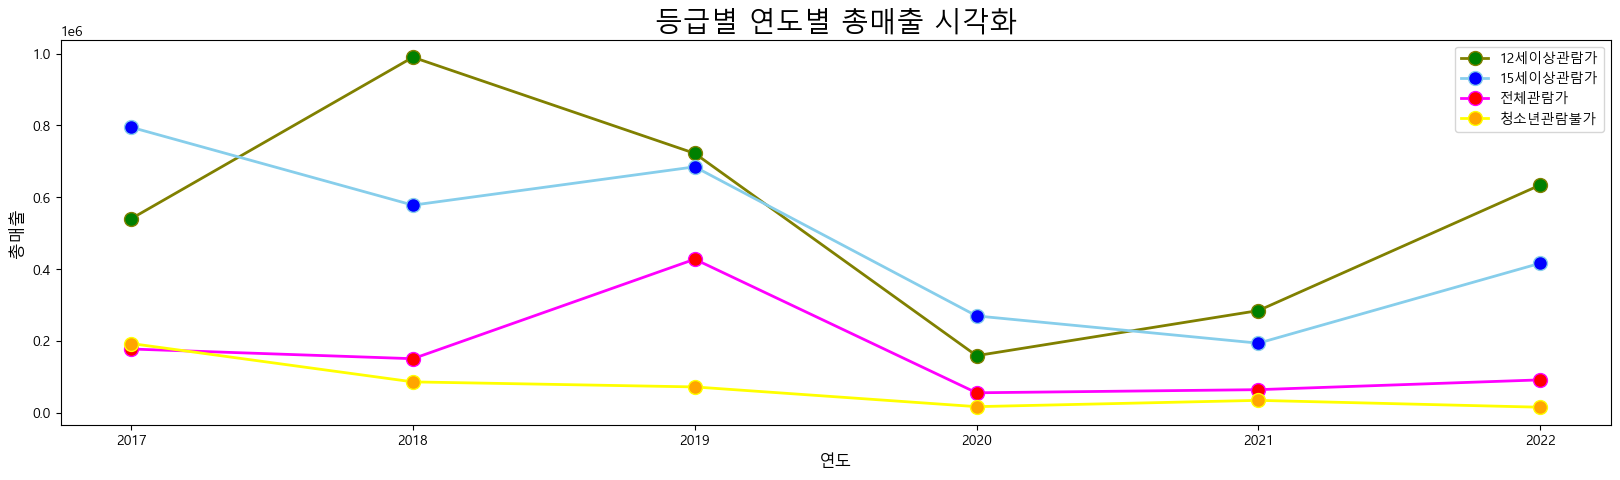

In [120]:
# 등급별 연도별 시각화
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)

grade_01 = grade_df_기준연도[grade_df_기준연도["등급"]=='12세이상관람가'][:-1]
grade_02 = grade_df_기준연도[grade_df_기준연도["등급"]=='15세이상관람가'][:-1]
grade_03 = grade_df_기준연도[grade_df_기준연도["등급"]=='전체관람가'][:-1]
grade_04 = grade_df_기준연도[grade_df_기준연도["등급"]=='청소년관람불가'][:-1]

ax.plot(grade_01['기준연도'], grade_01['총매출'], marker='o', markerfacecolor='green',
        markersize=10, color ="olive", linewidth=2, label='12세이상관람가')
ax.plot(grade_02['기준연도'], grade_02['총매출'], marker='o', markerfacecolor='blue',
        markersize=10, color ="skyblue", linewidth=2, label='15세이상관람가')
ax.plot(grade_03['기준연도'], grade_03['총매출'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='전체관람가')
ax.plot(grade_04['기준연도'], grade_04['총매출'], marker='o', markerfacecolor='orange',
        markersize=10, color ="yellow", linewidth=2, label='청소년관람불가')
ax.legend(loc="best")
ax.set_title('등급별 연도별 총매출 시각화', size=20)
ax.set_xlabel('연도',size=12)
ax.set_ylabel('총매출',size=12)
# ax.set_xticklabels(col_years, rotation = 90)
plt.show()

In [127]:
# 전체
grade_df_total = grade_df.groupby(['등급'])['매출액'].agg(['sum'])
grade_df_total

,sum
등급,
12세이상관람가,3586927572900
15세이상관람가,2981912008572
전체관람가,1010553852540
청소년관람불가,437018216622


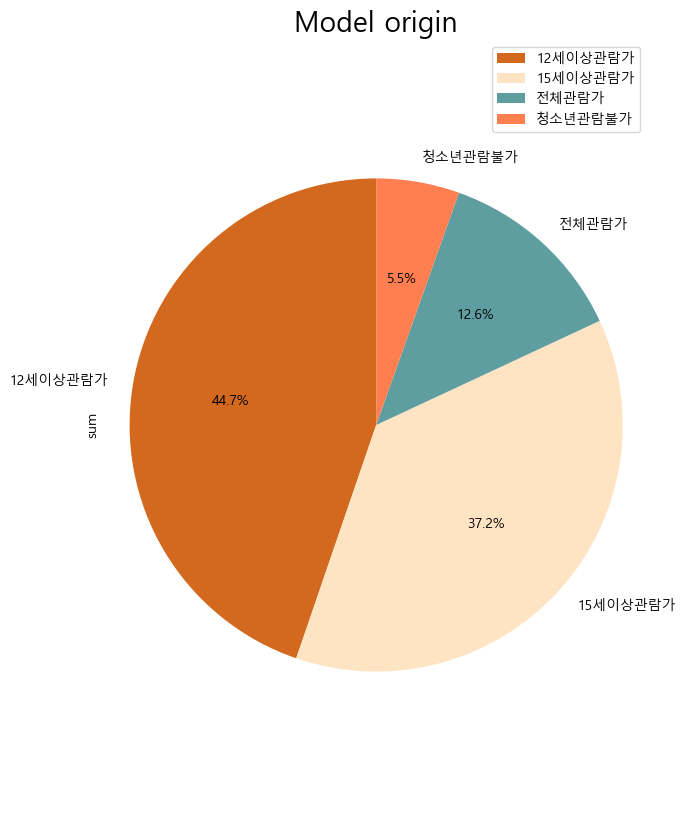

In [137]:
grade_df_total['sum'].plot(kind='pie', figsize=(7,10), autopct='%1.1f%%', 
                        startangle=90, # 파이조각을 나누는 시작점 (각도 표시)
                        colors=['chocolate','bisque','cadetblue','coral']) # 4개의 색상리스트
plt.title('Model origin', size=20)
plt.axis('equal') 
# 파이 차트의 비율을 같게(원에 가깝게) 조정
# 원의 형태를 유지할 수 있도록 써주는 것
plt.legend(labels = grade_df_total.index, loc='upper right')
plt.show()

# 분기별 장르

In [3]:
sales_quarter = movie_df[['영화명','기준연도','기준월','매출액','관객수','장르']].copy()
sales_quarter

,영화명,기준연도,기준월,매출액,관객수,장르
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스"
1,모아나,2017,1,7738000,910,애니메이션
2,패신저스,2017,1,1107502600,129810,"어드벤처,SF"
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,535436000,67605,"애니메이션,어드벤처,가족,판타지"
4,사랑하기 때문에,2017,1,450612400,53856,"코미디,멜로/로맨스"
...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,4881000,209,공연
183002,걱정말아요,2017,1,502000,71,드라마
183003,비밀객잔의 결투,2017,1,7000,2,"액션,어드벤처,드라마"
183004,소림사 무림 탐정-취의전장,2017,1,7000,2,액션


In [164]:
sales_quarter.isnull().sum()

영화명       0
기준연도      0
기준월       0
매출액       0
관객수       0
장르      105
dtype: int64

In [4]:
sales_quarter_genre = sales_quarter.dropna(subset=["장르"]).copy()
sales_quarter_genre

,영화명,기준연도,기준월,매출액,관객수,장르
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스"
1,모아나,2017,1,7738000,910,애니메이션
2,패신저스,2017,1,1107502600,129810,"어드벤처,SF"
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,535436000,67605,"애니메이션,어드벤처,가족,판타지"
4,사랑하기 때문에,2017,1,450612400,53856,"코미디,멜로/로맨스"
...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,4881000,209,공연
183002,걱정말아요,2017,1,502000,71,드라마
183003,비밀객잔의 결투,2017,1,7000,2,"액션,어드벤처,드라마"
183004,소림사 무림 탐정-취의전장,2017,1,7000,2,액션


In [121]:
sales_quarter['장르'].unique()

array(['애니메이션,드라마,멜로/로맨스', '애니메이션', '어드벤처,SF', '애니메이션,어드벤처,가족,판타지',
       '코미디,멜로/로맨스', '드라마', '공포(호러)', '액션', '액션,어드벤처,드라마',
       '스릴러,드라마,멜로/로맨스', '액션,어드벤처,판타지,SF', '어드벤처,스릴러', '다큐멘터리',
       '판타지,어드벤처,액션', '공연', '코미디', '멜로/로맨스', '범죄,드라마', '애니메이션,어드벤처,판타지',
       '드라마,스릴러', '공포(호러),스릴러', '스릴러', '멜로/로맨스,드라마', '성인물(에로)', '액션,전쟁',
       '액션,어드벤처,판타지', '액션,SF', '드라마,멜로/로맨스', '드라마,스릴러,미스터리',
       '애니메이션,SF,액션', '액션,범죄,스릴러', '범죄,액션', '애니메이션,액션,어드벤처', '애니메이션,가족',
       '드라마,전쟁', 'SF,액션,드라마', '드라마,범죄,미스터리', '판타지,액션',
       '애니메이션,어드벤처,가족,뮤지컬', '애니메이션,어드벤처', 'SF,드라마,스릴러', '액션,어드벤처,스릴러',
       '판타지,멜로/로맨스', '애니메이션,액션,코미디', '판타지,멜로/로맨스,코미디', '멜로/로맨스,스릴러',
       '애니메이션,드라마', 'SF,스릴러', '미스터리,멜로/로맨스,공포(호러)', '액션,드라마',
       '범죄,스릴러,드라마', '스릴러,드라마', '액션,범죄', '코미디,액션', '드라마,어드벤처',
       '멜로/로맨스,판타지,뮤지컬', '어드벤처,드라마,멜로/로맨스,SF', '액션,스릴러', '가족,드라마',
       '멜로/로맨스,코미디', '드라마,코미디', '미스터리,코미디', '액션,스릴러,드라마',
       '공포(호러),미스터리,스릴러', '애니메이션,코미디,액션', '애니메이션,판타지', '어드벤처', '판타지',
       '어드벤처,드

In [6]:
genre = []
for li in sales_quarter_genre['장르'].unique():
    if ',' in li:
        pass
    else:
        genre.append(li)
genre

['애니메이션',
 '드라마',
 '공포(호러)',
 '액션',
 '다큐멘터리',
 '공연',
 '코미디',
 '멜로/로맨스',
 '스릴러',
 '성인물(에로)',
 '어드벤처',
 '판타지',
 '기타',
 '범죄',
 'SF',
 '가족',
 '사극',
 '서부극(웨스턴)',
 '미스터리',
 '뮤지컬',
 '전쟁']

In [167]:
# 장르별 컬럼 만들기
for col in genre:
    sales_quarter_genre[col]=0
sales_quarter_genre["확인"]=0
sales_quarter_genre.head()

,영화명,기준연도,기준월,매출액,관객수,장르,애니메이션,드라마,공포(호러),액션,...,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁,확인
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,모아나,2017,1,7738000,910,애니메이션,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,패신저스,2017,1,1107502600,129810,"어드벤처,SF",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,535436000,67605,"애니메이션,어드벤처,가족,판타지",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,사랑하기 때문에,2017,1,450612400,53856,"코미디,멜로/로맨스",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
for i in tqdm(range(len(sales_quarter_genre))):
    cnt = 0
    for li in genre:
        if li in sales_quarter_genre.iloc[i]["장르"]:
            sales_quarter_genre[li][i]=1
            cnt +=1
    sales_quarter_genre["확인"][i]=cnt

  0%|          | 0/182901 [00:00<?, ?it/s]

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppDat

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppDat

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppDat

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppDat

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Lo

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppDat

C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre[li][i]=1
C:\Users\PC\AppData\Local\Temp\ipykernel_12600\2104300124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre["확인"][i]=cnt
C:\Users\PC\Ap

In [7]:
for col in genre:
    sales_quarter_genre[col]=sales_quarter_genre["장르"].apply(lambda x: 1 if col in x else 0)

In [8]:
sales_quarter_genre

,영화명,기준연도,기준월,매출액,관객수,장르,애니메이션,드라마,공포(호러),액션,...,판타지,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스",1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,모아나,2017,1,7738000,910,애니메이션,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,패신저스,2017,1,1107502600,129810,"어드벤처,SF",0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,535436000,67605,"애니메이션,어드벤처,가족,판타지",1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,사랑하기 때문에,2017,1,450612400,53856,"코미디,멜로/로맨스",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,4881000,209,공연,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183002,걱정말아요,2017,1,502000,71,드라마,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
183003,비밀객잔의 결투,2017,1,7000,2,"액션,어드벤처,드라마",0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
183004,소림사 무림 탐정-취의전장,2017,1,7000,2,액션,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
